In [4]:
import easytrader
import pandas as pd
import datetime
from WindPy import w
import requests
import datetime
from Portfolio import portfolio
import time
import matplotlib.pyplot as plt

In [5]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [1]:
position = {
    "160325.SZ":{
        "price":w.wsq('160325.SZ', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":0.857534
    }, 
    "161040.SZ":{
        "price":w.wsq('161040.SZ', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":0.90137
    }, 
    "501082.SH":{
        "price":w.wsq('501082.SH', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":0.947945
    }, 
    "506002.SH":{
        "price":w.wsq('506002.SH', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":0.986301
    },
    "160926.SZ":{
        "price":w.wsq('160926.SZ', 'rt_last').Data[0][0],
        "shares":0,
        "expiration":0.945205
    }
}

fee = 0.2/100

naive = portfolio(cash = 1000000, position = position, cost = fee)

NameError: name 'w' is not defined

In [25]:
def naive0(interval, times, portfolio):
    
    cur_times = 0
    
    log_df = pd.DataFrame()
    
    while cur_times != times:
        
        now = datetime.datetime.now()
        print(now)
        
        naive.get_balance()

        snapshot = {now : {}}
        for ticker, info in portfolio.position.items():
            
            code = ticker.split('.')[0]
            headers = {
                'content-type': 'application/json',
                'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:22.0) Gecko/20100101 Firefox/22.0'
            }
            response = requests.get(f'https://fundgz.1234567.com.cn/js/{code}.js', headers=headers)
            NAV = float(eval(response.text.replace('jsonpgz(', '').replace(');', ''))['gsz'])
            
            Price = w.wsq(ticker, 'rt_last').Data[0][0]
            info['price'] = Price
            
            AnnualizedRateOfReturn = ((NAV/Price)**(1/info['expiration'])-1)*100
            
            #NAV, Price, AnnualizedRateOfReturn
            snapshot[now][ticker + ' NAV'] = NAV
            snapshot[now][ticker + ' Price'] = Price
            snapshot[now][ticker + ' AnnualizedRateOfReturn'] = AnnualizedRateOfReturn
            
        tickerWithMaxAnnualizedRateOfReturn = max([(v, k) for k, v in snapshot[now].items() if 'AnnualizedRateOfReturn' in k])[1].split(' ')[0]
        print(tickerWithMaxAnnualizedRateOfReturn)
        
        trade = 0
        for k, v in snapshot[now].items():
            print(k, v)
        
        for ticker, info in portfolio.position.items():
            if ticker != tickerWithMaxAnnualizedRateOfReturn and info['shares'] != 0 and snapshot[now][tickerWithMaxAnnualizedRateOfReturn + ' AnnualizedRateOfReturn'] - snapshot[now][ticker + ' AnnualizedRateOfReturn'] >= 0:
                trade = 1
                cost = info['shares'] * info['Price'] * fee
                naive.sell(ticker, info['shares'], cost)
            elif ticker == tickerWithMaxAnnualizedRateOfReturn and naive.cash > 0:
                trade = 1
                cost = naive.cash * fee
                shares = (naive.cash - cost) / snapshot[now][tickerWithMaxAnnualizedRateOfReturn + ' Price']
                naive.buy(tickerWithMaxAnnualizedRateOfReturn, shares, cost)
        
        snapshot[now]['Capital'] = naive.get_capital()
        naive.get_balance()
            
        log_df = log_df.append(pd.DataFrame(snapshot).T)
            
        cur_times += 1
        time.sleep(interval)
        print()
    
    return log_df
            

In [54]:
def naive1(interval, times, portfolio):
    
    cur_times = 0
    
    log_df = pd.DataFrame()
    
    while cur_times != times:
        
        now = datetime.datetime.now()
        print(now)
        
        naive.get_balance()

        snapshot = {now : {}}
        for ticker, info in portfolio.position.items():
            
            code = ticker.split('.')[0]
            headers = {
                'content-type': 'application/json',
                'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:22.0) Gecko/20100101 Firefox/22.0'
            }
            response = requests.get(f'https://fundgz.1234567.com.cn/js/{code}.js', headers=headers)
            NAV = float(eval(response.text.replace('jsonpgz(', '').replace(');', ''))['gsz'])
            
            Price = w.wsq(ticker, 'rt_last').Data[0][0]
            info['price'] = Price
            
            AnnualizedRateOfReturn = ((NAV/Price)**(1/info['expiration'])-1)*100
            
            #NAV, Price, AnnualizedRateOfReturn
            snapshot[now][ticker + ' NAV'] = NAV
            snapshot[now][ticker + ' Price'] = Price
            snapshot[now][ticker + ' AnnualizedRateOfReturn'] = AnnualizedRateOfReturn
            
        tickerWithMaxAnnualizedRateOfReturn = max([(v, k) for k, v in snapshot[now].items() if 'AnnualizedRateOfReturn' in k])[1].split(' ')[0]
        print(tickerWithMaxAnnualizedRateOfReturn)
        
        trade = 0
        for k, v in snapshot[now].items():
            print(k, v)
        
        min_benchmark = 100
        zero_holding_ticker = None
        
        for ticker, info in portfolio.position.items():
            
            if snapshot[now][ticker + ' AnnualizedRateOfReturn'] < min_benchmark and info['shares'] != 0:
                
                min_ticker = ticker
                min_benchmark = snapshot[now][ticker + ' AnnualizedRateOfReturn']
            
            if info['shares'] == 0:
                
                zero_holding_ticker = ticker
                
        if snapshot[now][zero_holding_ticker + ' AnnualizedRateOfReturn'] - snapshot[now][min_ticker + ' AnnualizedRateOfReturn'] >= 1:
            
            trade = 1
            sell_cost = naive.position[min_ticker]['shares'] * naive.position[min_ticker]['price'] * fee
            naive.sell(min_ticker, naive.position[min_ticker]['shares'], sell_cost)
            
        snapshot[now]['Capital'] = naive.get_capital()
        naive.get_balance()
        buy_cost = naive.cash * fee
        buy_shares = (naive.cash - buy_cost)/snapshot[now][zero_holding_ticker + ' price']
        naive.buy(zero_holding_ticker, buy_shares, buy_cost)
          
            
        snapshot[now]['Capital'] = naive.get_capital()
        snapshot[now]['Trade'] = trade
        log_df = log_df.append(pd.DataFrame(snapshot).T)
            
        naive.get_balance()
        
        cur_times += 1
        time.sleep(interval)
        print()
    
    return log_df

In [55]:
log_df = naive1(1, 10, naive)

2021-08-05 15:28:00.277413
Cash: 1000000
160325.SZ: 
      Price:  1.17
      Shares     0
161040.SZ: 
      Price: 1.366
      Shares     0
501082.SH: 
      Price: 2.129
      Shares     0
506002.SH: 
      Price: 1.159
      Shares     0
160926.SZ: 
      Price: 1.209
      Shares     0
Capital: 1000000.0
160325.SZ
160325.SZ NAV 1.3334
160325.SZ Price 1.17
160325.SZ AnnualizedRateOfReturn 16.46805105821809
161040.SZ NAV 1.5162
161040.SZ Price 1.366
161040.SZ AnnualizedRateOfReturn 12.269879911035474
501082.SH NAV 2.4012
501082.SH Price 2.129
501082.SH AnnualizedRateOfReturn 13.532983746340355
506002.SH NAV 1.3246
506002.SH Price 1.159
506002.SH AnnualizedRateOfReturn 14.500375416662559
160926.SZ NAV 1.3864
160926.SZ Price 1.209
160926.SZ AnnualizedRateOfReturn 15.587099979387364


UnboundLocalError: local variable 'min_ticker' referenced before assignment

In [26]:
log_df = time_in_market(60, 30, naive)

2021-08-05 13:33:30.240204
Cash: 1000000
160325.SZ: 
      Price:  1.17
      Shares     0
161040.SZ: 
      Price:  1.37
      Shares     0
501082.SH: 
      Price: 2.137
      Shares     0
506002.SH: 
      Price:  1.16
      Shares     0
160926.SZ: 
      Price: 1.212
      Shares     0
Capital: 1000000.0
160325.SZ
160325.SZ NAV 1.3401
160325.SZ Price 1.17
160325.SZ AnnualizedRateOfReturn 17.150783897262343
161040.SZ NAV 1.5194
161040.SZ Price 1.37
161040.SZ AnnualizedRateOfReturn 12.168331164711855
501082.SH NAV 2.4135
501082.SH Price 2.137
501082.SH AnnualizedRateOfReturn 13.695837288218016
506002.SH NAV 1.33
506002.SH Price 1.16
506002.SH AnnualizedRateOfReturn 14.873164783916204
160926.SZ NAV 1.3934
160926.SZ Price 1.212
160926.SZ AnnualizedRateOfReturn 15.900339452306023
Buy 160325.SZ : 852991.452991453 shares | -998000.0 expense - 2000.0 cost = -1000000.0
Cash:   0.0
160325.SZ: 
      Price:  1.17
      Shares 852991.452991453
161040.SZ: 
      Price:  1.37
      Shares     0



2021-08-05 13:42:28.428204
Cash:   0.0
160325.SZ: 
      Price: 1.171
      Shares 852991.452991453
161040.SZ: 
      Price: 1.369
      Shares     0
501082.SH: 
      Price: 2.1310000000000002
      Shares     0
506002.SH: 
      Price: 1.159
      Shares     0
160926.SZ: 
      Price:  1.21
      Shares     0
Capital: 998852.9914529915
160325.SZ
160325.SZ NAV 1.3379
160325.SZ Price 1.171
160325.SZ AnnualizedRateOfReturn 16.810107839876864
161040.SZ NAV 1.5187
161040.SZ Price 1.368
161040.SZ AnnualizedRateOfReturn 12.292855513977008
501082.SH NAV 2.41
501082.SH Price 2.1310000000000002
501082.SH AnnualizedRateOfReturn 13.859119167389267
506002.SH NAV 1.3247
506002.SH Price 1.159
506002.SH AnnualizedRateOfReturn 14.509139629466805
160926.SZ NAV 1.3918
160926.SZ Price 1.21
160926.SZ AnnualizedRateOfReturn 15.961984017913133
Cash:   0.0
160325.SZ: 
      Price: 1.171
      Shares 852991.452991453
161040.SZ: 
      Price: 1.368
      Shares     0
501082.SH: 
      Price: 2.13100000000000

160325.SZ
160325.SZ NAV 1.3375
160325.SZ Price 1.171
160325.SZ AnnualizedRateOfReturn 16.769383446161434
161040.SZ NAV 1.5178
161040.SZ Price 1.368
161040.SZ AnnualizedRateOfReturn 12.21903017341055
501082.SH NAV 2.4093
501082.SH Price 2.132
501082.SH AnnualizedRateOfReturn 13.767912780199577
506002.SH NAV 1.327
506002.SH Price 1.16
506002.SH AnnualizedRateOfReturn 14.61045761859232
160926.SZ NAV 1.391
160926.SZ Price 1.211
160926.SZ AnnualizedRateOfReturn 15.790222363150397
Cash:   0.0
160325.SZ: 
      Price: 1.171
      Shares 852991.452991453
161040.SZ: 
      Price: 1.368
      Shares     0
501082.SH: 
      Price: 2.132
      Shares     0
506002.SH: 
      Price:  1.16
      Shares     0
160926.SZ: 
      Price: 1.211
      Shares     0
Capital: 998852.9914529915

2021-08-05 13:50:43.144204
Cash:   0.0
160325.SZ: 
      Price: 1.171
      Shares 852991.452991453
161040.SZ: 
      Price: 1.368
      Shares     0
501082.SH: 
      Price: 2.132
      Shares     0
506002.SH: 
      P


2021-08-05 13:57:56.886204
Cash:   0.0
160325.SZ: 
      Price: 1.171
      Shares 852991.452991453
161040.SZ: 
      Price: 1.368
      Shares     0
501082.SH: 
      Price:  2.13
      Shares     0
506002.SH: 
      Price: 1.159
      Shares     0
160926.SZ: 
      Price:  1.21
      Shares     0
Capital: 998852.9914529915
160325.SZ
160325.SZ NAV 1.3343
160325.SZ Price 1.172
160325.SZ AnnualizedRateOfReturn 16.327808494579998
161040.SZ NAV 1.5141
161040.SZ Price 1.366
161040.SZ AnnualizedRateOfReturn 12.097379538779741
501082.SH NAV 2.4042
501082.SH Price 2.13
501082.SH AnnualizedRateOfReturn 13.626321160828446
506002.SH NAV 1.3212
506002.SH Price 1.158
506002.SH AnnualizedRateOfReturn 14.302388396135136
160926.SZ NAV 1.3872
160926.SZ Price 1.21
160926.SZ AnnualizedRateOfReturn 15.556541793717106
Cash:   0.0
160325.SZ: 
      Price: 1.172
      Shares 852991.452991453
161040.SZ: 
      Price: 1.366
      Shares     0
501082.SH: 
      Price:  2.13
      Shares     0
506002.SH: 
    

<AxesSubplot:>

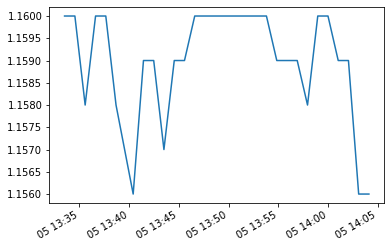

In [42]:
log_df['506002.SH Price'].plot()

In [1]:
import easytrader

In [2]:
user = easytrader.use('ht_client')

In [3]:
user.prepare(user='666637575127', password='671109', comm_password='671109')

c:\users\rtamc-f\appdata\local\programs\python\python38\lib\site-packages\pywinauto\application.py:1062: UserWarning: 32-bit application should be automated using 32-bit Python (you use 64-bit Python)
  warnings.warn(
c:\users\rtamc-f\appdata\local\programs\python\python38\lib\site-packages\pywinauto\application.py:1062: UserWarning: 32-bit application should be automated using 32-bit Python (you use 64-bit Python)
  warnings.warn(


TimeoutError: timed out

In [8]:
price = w.wsq('511880.SH', 'rt_last').Data[0][0]

In [9]:
price

101.404

In [10]:
user.buy('511880', price, 1000)

TradeError: 提交失败：[251070][校验上海指定交易失败，上海的未指定户或者在委托托管股票类别不是X,1] [stock_account=A360822222,regflag=0] 。

In [11]:
user.exit()

In [ ]:
666637575127
671109
671109

In [28]:
log_df.columns

Index(['160325.SZ AnnualizedRateOfReturn', '160325.SZ NAV', '160325.SZ Price',
       '160926.SZ AnnualizedRateOfReturn', '160926.SZ NAV', '160926.SZ Price',
       '161040.SZ AnnualizedRateOfReturn', '161040.SZ NAV', '161040.SZ Price',
       '501082.SH AnnualizedRateOfReturn', '501082.SH NAV', '501082.SH Price',
       '506002.SH AnnualizedRateOfReturn', '506002.SH NAV', '506002.SH Price',
       'Capital'],
      dtype='object')

<AxesSubplot:>

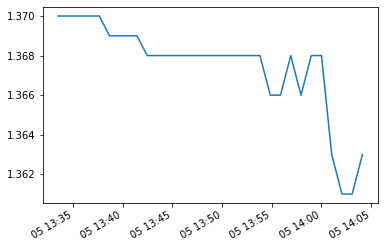

In [29]:
log_df['161040.SZ Price'].plot()

In [33]:


for index, row in market.iterrows():
    print(index.strftime('%Y-%m-%d'))
    print()
    trade = 0
    
    
    for ticker, info in naive.position.items():
        if ticker != row['Highest'] and info['shares'] != 0 and row[row['Highest'] + ' return rate/year (%)'] - row[ticker + ' return rate/year (%)'] >= 0:
            trade = 1
            cost = info['shares'] * info['price'] * fee
            naive.sell(ticker, info['shares'], cost)
        elif ticker == row['Highest'] and naive.cash > 0:
            trade = 1
            cost = naive.cash * fee
            shares = (naive.cash - cost) / row[row['Highest'] + ' price']
            naive.buy(row['Highest'], shares, cost)
    
    print()
    capital = naive.get_capital()
    naive.get_balance()
    log_df = log_df.append(pd.Series([
        naive.position['160325']['shares'], 
        naive.position['161040']['shares'], 
        naive.position['501082']['shares'], 
        naive.position['506002']['shares'],
        capital,
        trade],
        index = ['160325 shares', '161040 shares', '501082 shares', '506002 shares', 'Capital', 'Trade']), ignore_index=True)
    
    trade_count += trade
    print('--'*40)

In [10]:
log_df['160325.SZ Price'].plot()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [34]:
naive.get_balance()

Cash: 1000000
160325: 
      Price: 1.166
      Shares     0
161040: 
      Price: 1.368
      Shares     0
501082: 
      Price: 2.138
      Shares     0
506002: 
      Price: 1.157
      Shares     0


In [ ]:
0.945205
market['160325 return rate/year (%)'] = ((market['160325 NAV']/market['160325 price'])**(1/0.857534)-1)*100
market['501082 return rate/year (%)'] = ((market['501082 NAV']/market['501082 price'])**(1/0.90137)-1)*100
market['161040 return rate/year (%)'] = ((market['161040 NAV']/market['161040 price'])**(1/0.947945)-1)*100
market['506002 return rate/year (%)'] = ((market['506002 NAV']/market['506002 price'])**(1/0.986301)-1)*100